<a href="https://colab.research.google.com/github/Kritikargv17/Deep-Learning-LAB/blob/main/Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
import seaborn as sns
import pandas as pd

In [2]:
# Load Dataset
file_path = "BMW_Car_Sales_Classification.csv"
df = pd.read_csv(file_path)


In [3]:
TARGET_COL = "Sales_Classification"

# Encode categorical features
cat_cols = ["Model", "Region", "Color", "Fuel_Type", "Transmission"]
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Encode target
le_target = LabelEncoder()
df[TARGET_COL] = le_target.fit_transform(df[TARGET_COL])

# Features and target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Standardize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = SimpleNN(input_dim=X.shape[1], hidden_dim=64, output_dim=len(le_target.classes_))

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    acc = correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Acc: {acc:.4f}")

Epoch 1/50, Loss: 0.0481, Acc: 0.9467
Epoch 2/50, Loss: 0.0215, Acc: 0.9896
Epoch 3/50, Loss: 0.0718, Acc: 0.9919
Epoch 4/50, Loss: 0.0157, Acc: 0.9942
Epoch 5/50, Loss: 0.0107, Acc: 0.9953
Epoch 6/50, Loss: 0.0073, Acc: 0.9962
Epoch 7/50, Loss: 0.0089, Acc: 0.9965
Epoch 8/50, Loss: 0.0159, Acc: 0.9965
Epoch 9/50, Loss: 0.0203, Acc: 0.9971
Epoch 10/50, Loss: 0.0025, Acc: 0.9973
Epoch 11/50, Loss: 0.0119, Acc: 0.9975
Epoch 12/50, Loss: 0.0040, Acc: 0.9974
Epoch 13/50, Loss: 0.0007, Acc: 0.9976
Epoch 14/50, Loss: 0.0004, Acc: 0.9976
Epoch 15/50, Loss: 0.0064, Acc: 0.9981
Epoch 16/50, Loss: 0.0055, Acc: 0.9980
Epoch 17/50, Loss: 0.0066, Acc: 0.9977
Epoch 18/50, Loss: 0.0106, Acc: 0.9982
Epoch 19/50, Loss: 0.0116, Acc: 0.9982
Epoch 20/50, Loss: 0.0040, Acc: 0.9981
Epoch 21/50, Loss: 0.0020, Acc: 0.9982
Epoch 22/50, Loss: 0.0083, Acc: 0.9982
Epoch 23/50, Loss: 0.0085, Acc: 0.9984
Epoch 24/50, Loss: 0.0028, Acc: 0.9982
Epoch 25/50, Loss: 0.0020, Acc: 0.9984
Epoch 26/50, Loss: 0.0017, Acc: 0.

In [5]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(batch_y.numpy())
        y_pred.extend(predicted.numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("\n--- Performance Metrics ---")
print(f"Accuracy: {acc:.4f}")

# Binary classification: sensitivity & specificity
if len(le_target.classes_) == 2:
    sensitivity = recall_score(y_true, y_pred, pos_label=1)
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP)
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
else:
    # Multi-class metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))




--- Performance Metrics ---
Accuracy: 0.9975
Sensitivity (Recall): 0.9978
Specificity: 0.9967


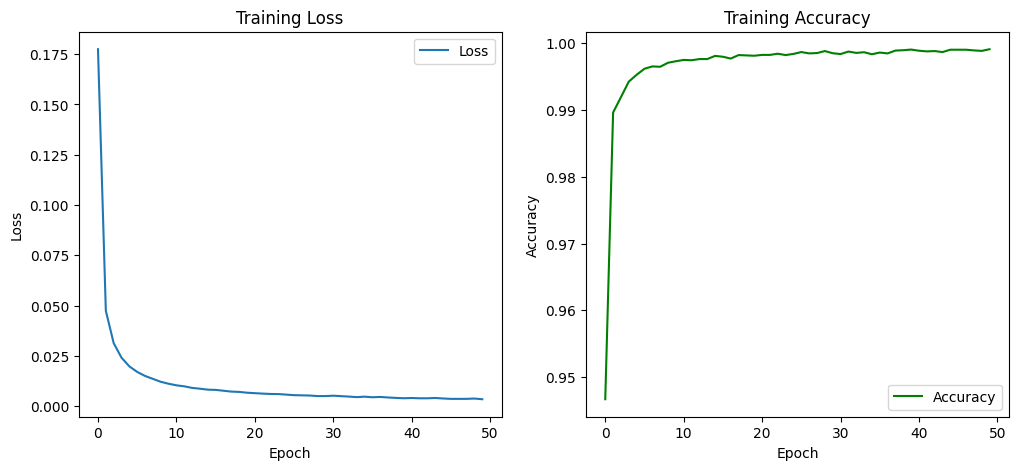

In [6]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

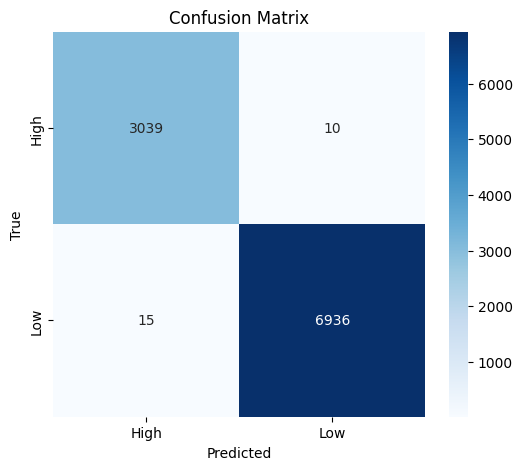

In [7]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
